# Convert a Tensorflow Lite Model to OpenVINOâ„¢

[TensorFlow Lite](https://www.tensorflow.org/lite/guide), often referred to as TFLite, is an open source library developed for deploying machine learning models to edge devices. 

This short tutorial shows how to convert a TensorFlow Lite [efficientnet-lite-b0](https://tfhub.dev/tensorflow/lite-model/efficientnet/lite0/fp32/2) image classification model to OpenVINO [Intermediate Representation](https://docs.openvino.ai/2023.0/openvino_docs_MO_DG_IR_and_opsets.html) (OpenVINO IR) format, using [Model Optimizer](https://docs.openvino.ai/2023.0/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html). After creating the OpenVINO IR, load the model in [OpenVINO Runtime](https://docs.openvino.ai/nightly/openvino_docs_OV_UG_OV_Runtime_User_Guide.html) and do inference with a sample image.

## Preparation

### Install requirements

In [ ]:
!pip install -q "openvino-dev>=2023.0.0"
!pip install -q opencv-python requests tqdm

# Fetch `notebook_utils` module
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)

### Imports

In [ ]:
from pathlib import Path
import numpy as np
from PIL import Image
from openvino.runtime import Core, serialize
from openvino.tools import mo

from notebook_utils import download_file, load_image

## Download TFLite model


In [ ]:
model_dir = Path("model")
tflite_model_path = model_dir / "efficientnet_lite0_fp32_2.tflite"

ov_model_path = tflite_model_path.with_suffix(".xml")
model_url = "https://tfhub.dev/tensorflow/lite-model/efficientnet/lite0/fp32/2?lite-format=tflite"

download_file(model_url, tflite_model_path.name, model_dir)

## Convert a Model to OpenVINO IR Format

To convert the TFLite model to OpenVINO IR, OpenVINO Model Optimizer Python API can be used. `mo.convert_model` function accept path to TFLite model and returns OpenVINO Model class instance which represents this model. Obtained model is ready to use and loading on device using `compile_model` or can be saved on disk using `serialize` function reducing loading time for next running. Optionally, we can apply compression to FP16 model weigths using `compress_to_fp16=True` option and integrate preprocessing using this approach.
See the [Model Optimizer Developer Guide](https://docs.openvino.ai/2023.0/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) for more information about Model Optimizer and TensorFlow Lite [models suport](https://docs.openvino.ai/2023.0/openvino_docs_MO_DG_prepare_model_convert_model_Convert_Model_From_TensorFlow_Lite.html).

In [ ]:
ov_model = mo.convert_model(tflite_model_path, compress_to_fp16=True)
serialize(ov_model, ov_model_path)
print(f"Model {tflite_model_path} successfully converted and saved to {ov_model_path}")

Model model/efficientnet_lite0_fp32_2.tflite successfully converted and saved to model/efficientnet_lite0_fp32_2.xml


## Load model using OpenVINO TensorFlow Lite Frontend

TensorFlow Lite models are supported via FrontEnd API. You may skip conversion to IR and read models directly by OpenVINO runtime API. For more examples supported formats reading via Frontend API, please look this [tutorial](../002-openvino-api).

In [ ]:
core = Core()

ov_model = core.read_model(tflite_model_path)

## Run OpenVINO model inference

We can find information about model input preprocessing in its [description](https://tfhub.dev/tensorflow/lite-model/efficientnet/lite0/fp32/2) on [TensorFlow Hub](https://tfhub.dev/).

In [ ]:
image = load_image("https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_bricks.png")
# load_image reads the image in BGR format, [:,:,::-1] reshape transfroms it to RGB
image = Image.fromarray(image[:,:,::-1])
resized_image = image.resize((224, 224))
input_tensor = np.expand_dims((np.array(resized_image).astype(np.float32) - 127) / 128, 0)

In [ ]:
compiled_model = core.compile_model(ov_model)
predicted_scores = compiled_model(input_tensor)[0]

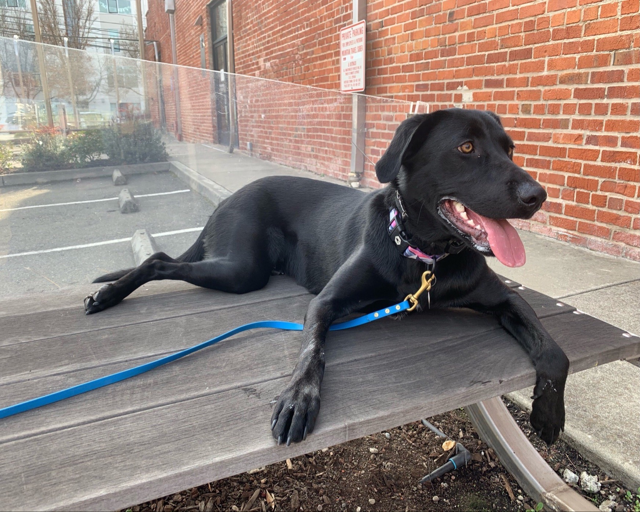

Predicted label: n02109047 Great Dane with probability 0.715318


In [ ]:
imagenet_classes_file_path = download_file("https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/datasets/imagenet/imagenet_2012.txt")
imagenet_classes = open(imagenet_classes_file_path).read().splitlines()

top1_predicted_cls_id = np.argmax(predicted_scores)
top1_predicted_score = predicted_scores[0][top1_predicted_cls_id]
predicted_label = imagenet_classes[top1_predicted_cls_id]

display(image.resize((640, 512)))
print(f"Predicted label: {predicted_label} with probability {top1_predicted_score :2f}")

## Estimate Model Performance
[Benchmark Tool](https://docs.openvino.ai/latest/openvino_inference_engine_tools_benchmark_tool_README.html) is used to measure the inference performance of the  model on CPU and GPU.

> **NOTE**: For more accurate performance, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications. Run `benchmark_app -m model.xml -d CPU` to benchmark async inference on CPU for one minute. Change `CPU` to `GPU` to benchmark on GPU. Run `benchmark_app --help` to see an overview of all command-line options.

In [ ]:
print("Benchmark model inference on CPU")
!benchmark_app -m $ov_model_path -d CPU -t 15
if "GPU" in core.available_devices:
    print("\n\nBenchmark model inference on GPU")
    !benchmark_app -m $ov_model_path -d GPU -t 15